In [56]:
from nn_grad import Node
from nn_loss import MinsqrLoss, MinsqrLoss
from nn_optimizer import AdamOptim, StochasticOptim
from nn_layer import *
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt

In [57]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

In [58]:
data = np.c_[housing.data, housing.target]
columns = np.append(housing.feature_names, ["target"])
dataframe = pd.DataFrame(data, columns=columns)

In [59]:
dataframe.to_csv('./data.csv')

In [60]:
dataframe.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'target'],
      dtype='object')

In [61]:

dt = dataframe.to_numpy()

In [62]:
x_ = dt[:, 0:8]
y_ = dt[:, 8]

y_ = y_.reshape(len(y_), 1)

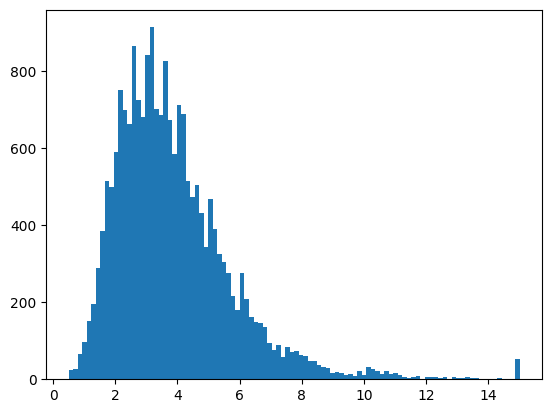

In [63]:

plt.hist(x_[:, 0], bins=100)
plt.show()

In [64]:
dataframe = dataframe.assign(IncomeClass=pd.Series(np.zeros(len(dataframe))).values)

dataframe.loc[dataframe.MedInc < 2, 'IncomeClass'] = 0

dataframe.loc[ (dataframe.MedInc >= 2) &  (dataframe.MedInc < 4), 'IncomeClass'] = 1

dataframe.loc[ (dataframe.MedInc >= 4) &  (dataframe.MedInc < 6), 'IncomeClass'] = 2

dataframe.loc[ (dataframe.MedInc >= 6), 'IncomeClass'] = 3


(array([ 2439.,     0.,     0., 10077.,     0.,     0.,  5751.,     0.,
            0.,  2373.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

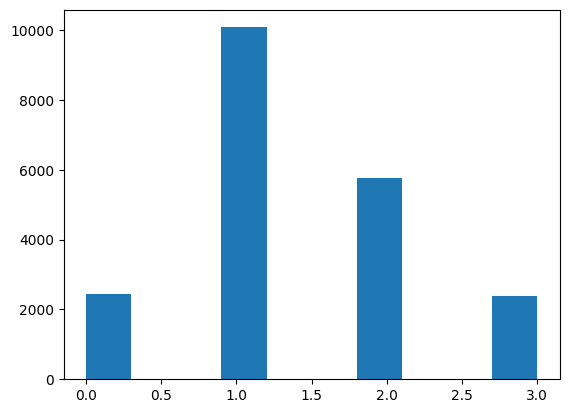

In [65]:
plt.hist(dataframe.loc[:, 'IncomeClass'])

In [66]:
dt = dataframe.to_numpy()
x_ = dt[:, 1:8]
y_ = dt[:, 9]

y_ = np.array([[1, 0, 0, 0] if y == 0 else
               [0, 1, 0, 0] if y == 1 else
               [0, 0, 1, 0] if y == 2 else
               [0, 0, 0, 1]
               for y in y_])

In [67]:

x_train, x_test, y_train,y_test = train_test_split(x_, y_, test_size=0.25, shuffle=True)

In [68]:
from nn_layer import nnLayer

from nn_loss import *


class nnImpl:

    def __init__(self, in_dim, out_dim):

        self.with_bias = True
        self.layers: np.ndarray[nnLayer] = [
            LinearLayer(in_dim, 16, with_bias=self.with_bias, kernel=Node.dot),
            SigmoidLayer(16, 24, with_bias=self.with_bias, kernel=Node.dot),
            ReluLayer(24, 16, with_bias=self.with_bias, kernel=Node.dot),
            LinearLayer(16, 8, with_bias=self.with_bias, kernel=Node.dot),
            SoftargmaxLayer(8, out_dim, with_bias=self.with_bias, kernel=Node.dot)]

    def forward(self, x_: Node) -> Node:
        for layer in self.layers:
            x_ = layer.forward(x_)
        return x_

In [55]:

np.seterr(all='ignore')

n = x_train.shape[0]
net = nnImpl(x_train.shape[1], y_train.shape[1])

indxs = list(range(0, n))
epochs = 10 ** 3 * 5

optim = AdamOptim(net, lr=10**-4)
loss = LogLoss()

acc_scores = []
f1_scores = []
loss_scores = []

arg_train = np.argmax(y_train, 1)
arg_test = np.argmax(y_test, 1)

for epoch in range(0, epochs + 1):
    y_train_pred = net.forward(Node(x_train))
    loss_ = loss.backward(y_train_pred, y_train)  
    optim.descend()
    
    if epoch % 10 ** 2 == 0:

        train_loss = loss_.val / y_train.shape[0] / y_train.shape[1]
        print(f'epoch: {epoch} loss value: {train_loss}')
        
        if epoch % 10 ** 3:
            y_test_pred = net.forward(Node(x_test))
            
            test_loss = loss.count_loss(
                y_test_pred, y_test).val / y_train.shape[0] / y_train.shape[1]


            train_res = np.argmax(y_train_pred.val, axis=1)
            test_res = np.argmax(y_test_pred.val, axis=1)

            train_acc = accuracy_score(arg_train, train_res)
            test_acc = accuracy_score(arg_test, test_res)

            train_f1 = f1_score(arg_train, train_res, average='micro')
            test_f1 = f1_score(arg_test, test_res, average='micro')

            acc_scores.append([train_acc, test_acc, epoch])
            f1_scores.append([train_f1, test_f1, epoch])
            loss_scores.append([train_loss, test_loss, epoch])
        
            np.random.shuffle(indxs)
            x_train = x_train[indxs]
            y_train = y_train[indxs]              
          
        if train_loss < 0.3:
            break
    

epoch: 0 loss value: 0.5259686844824583
epoch: 100 loss value: 0.4659694322439539


AttributeError: 'LogLoss' object has no attribute 'count_loss'

In [45]:

def display(loss_scores, f1_scores, acc_scores):
    loss_scores = np.array(loss_scores)
    f1_scores = np.array(f1_scores)
    acc_scores = np.array(acc_scores)

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss score')
    plt.plot(loss_scores[:, 1], loss_scores[:, 0], label='loss during train')
    plt.legend()
    plt.show()

    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy score')
    plt.plot(acc_scores[:, 2], acc_scores[:, 0], label='train')
    plt.plot(acc_scores[:, 2], acc_scores[:, 1], label='test')
    plt.legend()
    plt.show()

    plt.xlabel('epoch')
    plt.ylabel('f1')
    plt.title('F1 score')
    plt.plot(f1_scores[:, 2], f1_scores[:, 0], label='train')
    plt.plot(f1_scores[:, 2], f1_scores[:, 1], label='test')
    plt.legend()
    plt.show()


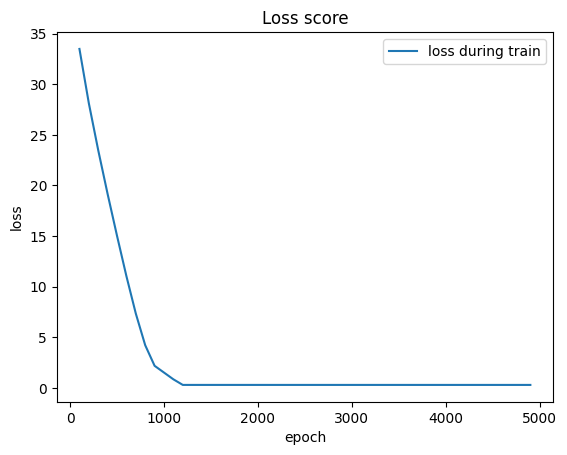

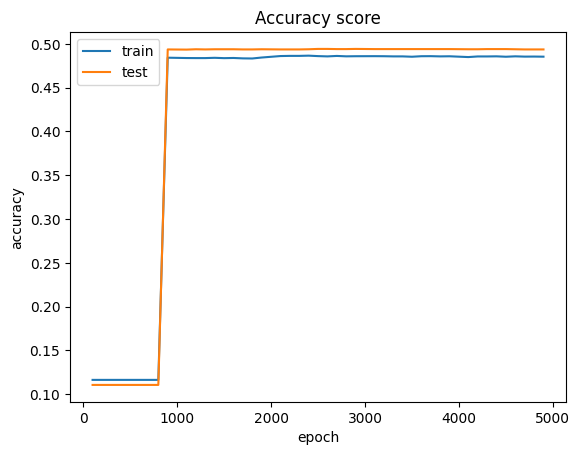

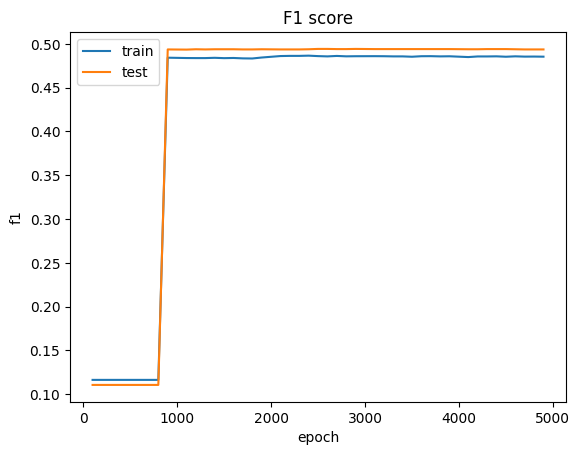

In [46]:
display(loss_scores, f1_scores, acc_scores)

In [51]:
from nn_layer import nnLayer

from nn_loss import *


class nnImplGauss:

    def __init__(self, in_dim, out_dim):
        self.with_bias = True
        self.layers: np.ndarray[nnLayer] = [
            LinearLayer(in_dim, 16, with_bias=self.with_bias, kernel=Node.gauss),
            ReluLayer(16, 4, with_bias=self.with_bias, kernel=Node.gauss),
            LinearLayer(4, 8, with_bias=self.with_bias, kernel=Node.gauss),
            SoftargmaxLayer(8, out_dim, with_bias=self.with_bias, kernel=Node.gauss)]

    def forward(self, x_: Node) -> Node:
        for layer in self.layers:
            x_ = layer.forward(x_)
        return x_

In [53]:

np.seterr(all='ignore')

n = x_train.shape[0]
net = nnImplGauss(x_train.shape[1], y_train.shape[1])

indxs = list(range(0, n))
epochs = 10 ** 3 * 5

optim = AdamOptim(net, lr=10**-4)
loss = LogLoss()

acc_scores = []
f1_scores = []
loss_scores = []

arg_train = np.argmax(y_train, 1)
arg_test = np.argmax(y_test, 1)



for epoch in range(0, epochs + 1):
    y_train_pred = net.forward(Node(x_train))
    loss_ = loss.backward(y_train_pred, Node(y_train))  
    optim.descend()
    
    if epoch % 10 ** 2 == 0:
        
        val_loss = loss_.val / y_train.shape[0] / y_train.shape[1]
        print(f'epoch: {epoch} loss value: {val_loss}')
        
        if epoch % 10 ** 3:
            y_test_pred = net.forward(Node(x_test))

            train_res = np.argmax(y_train_pred.val, axis=1)
            test_res = np.argmax(y_test_pred.val, axis=1)

            train_acc = accuracy_score(arg_train, train_res)
            test_acc = accuracy_score(arg_test, test_res)

            train_f1 = f1_score(arg_train, train_res, average='micro')
            test_f1 = f1_score(arg_test, test_res, average='micro')

            acc_scores.append([train_acc, test_acc, epoch])
            f1_scores.append([train_f1, test_f1, epoch])
            loss_scores.append([val_loss, epoch])
        
            np.random.shuffle(indxs)
            x_train = x_train[indxs]
            y_train = y_train[indxs]              
          
        if val_loss < 0.3:
            break
    

epoch: 0 loss value: 0.3530028883393279
epoch: 100 loss value: 0.34996119182088514
epoch: 200 loss value: 0.3482677692175584
epoch: 300 loss value: 0.34684998109417137
epoch: 400 loss value: 0.34554505131858493
epoch: 500 loss value: 0.34430275232226965
epoch: 600 loss value: 0.3431018754648945
epoch: 700 loss value: 0.3419312317838849
epoch: 800 loss value: 0.34078329367349897
epoch: 900 loss value: 0.339646547942159
epoch: 1000 loss value: 0.33847231198390854
epoch: 1100 loss value: 0.33711167779657564
epoch: 1200 loss value: 0.335295538592078
epoch: 1300 loss value: 0.33269124053756616
epoch: 1400 loss value: 0.3291477844451338
epoch: 1500 loss value: 0.324818126855932
epoch: 1600 loss value: 0.3204660855433256
epoch: 1700 loss value: 0.3166853696288741
epoch: 1800 loss value: 0.3136302704757827
epoch: 1900 loss value: 0.3112472753036643
epoch: 2000 loss value: 0.30938295021360207
epoch: 2100 loss value: 0.30789346559235803
epoch: 2200 loss value: 0.3066917033776878
epoch: 2300 loss

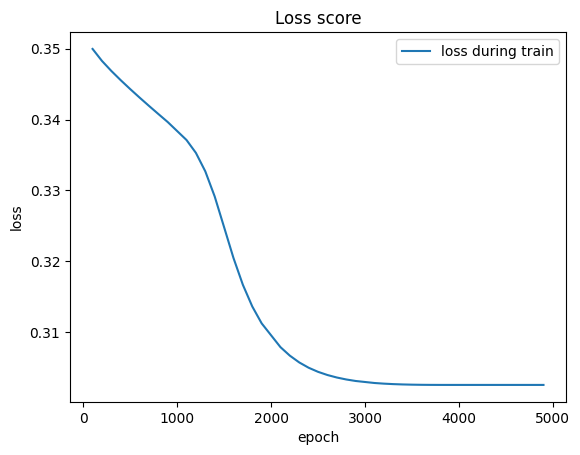

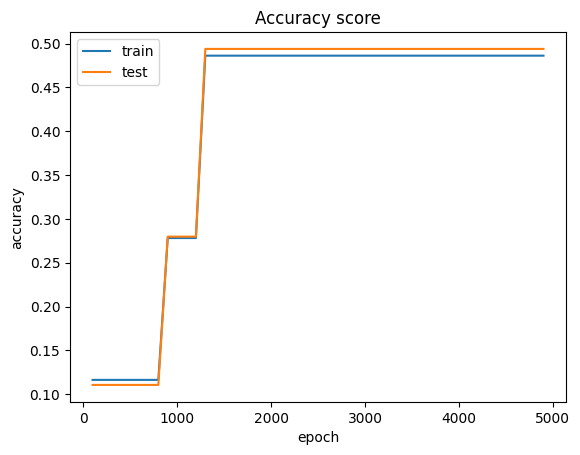

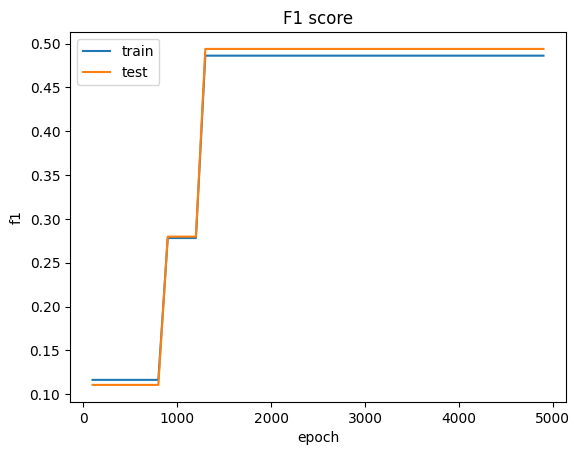

In [54]:
display(loss_scores, f1_scores, acc_scores)
